## Observations:

zip is available in address - index on split is -1, -5:

potential interests:

- zip code (reduced to large(-ish?) sample sizes)
- maybe look at geographical location specifically? (Is proximity to city center and features calculable?| $\checkmark$)
  - look into part 2 ^
  - waterfront is listed as a binary column
- (person pref, focus on home buyers/individuals)
- someone mentioned school data - this isn't a bad idea.
  - can get school rankings and their zip codes

would like to get external/additional information. Will check Kaggle for related data sets

https://kingcounty.gov/ <= city website

find out if prices are based on closes or valuations - if closes, can

### Data cleaning

- multiple y/n / cat. columns that can be converted to dummies for OLS discovery
- view quality can be rated as good/bad/avg. , could be extrapolated to 0-2 (more if more options there)
- grade?

<hr/>
Data from [column_names.md](data/column_names.md)  
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

- `view` - Quality of view from house
  - Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
- `condition` - How good the overall condition of the house is. Related to maintenance of house.
  - See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
- `grade` - Overall grade of the house. Related to the construction and design of the house.
  - See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
  <hr/>

lots of relevant info for discovery in there


# _*IMPORTANT*_

Most fields were pulled from the [King County Assessor Data Download](https://info.kingcounty.gov/assessor/DataDownload/default.aspx).

The `address`, `lat`, and `long` fields have been retrieved using a third-party [geocoding API](https://docs.mapbox.com/api/search/geocoding/). In some cases due to missing or incorrectly-entered data from the King County Assessor, this API returned locations outside of King County, WA. If you plan to use the `address`, `lat`, or `long` fields in your modeling, consider identifying outliers prior to including the values in your model

<br/><hr/><br/><hr/>


### imports


In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from code.features import has_feature
import numpy as np
from random import gauss, seed
from scipy import stats
import seaborn as sns
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

dfs:  
    housing data - provided by FlatIron School  
    zip codes: cross referenced with zip-codes.com  
    nearby_zips - pulled from https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/

In [105]:
housing_df = pd.read_csv('data/kc_house_data.csv')
zip_codes = pd.read_csv('data/King_County_Zip_Codes.csv')
nearby_zips_df = pd.read_csv('data/counties_5_mile.csv')

## Variable Definitions

In [106]:
sns.set()

In [107]:
alpha = 0.05            # default confidence 
upper_cost = 5000000    # <= $5,000,

## DataFrame Definitions

In [108]:
housing_df['zip'] = housing_df['address'].map(lambda x: x.split(',')[-2][-5:])
housing_df['town']= housing_df['address'].map(lambda x: x.split(',')[-3].strip())
housing_df.drop(columns=['address','lat','long', 'heat_source', 'grade', 'sewer_system', 'nuisance'], inplace = True)
kc_only = housing_df.merge(zip_codes['Zip Codes'].astype(str),left_on='zip',right_on='Zip Codes',how='inner')

In [109]:
display(kc_only.describe(), kc_only.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29189 entries, 0 to 29188
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             29189 non-null  int64  
 1   date           29189 non-null  object 
 2   price          29189 non-null  float64
 3   bedrooms       29189 non-null  int64  
 4   bathrooms      29189 non-null  float64
 5   sqft_living    29189 non-null  int64  
 6   sqft_lot       29189 non-null  int64  
 7   floors         29189 non-null  float64
 8   waterfront     29189 non-null  object 
 9   greenbelt      29189 non-null  object 
 10  view           29189 non-null  object 
 11  condition      29189 non-null  object 
 12  sqft_above     29189 non-null  int64  
 13  sqft_basement  29189 non-null  int64  
 14  sqft_garage    29189 non-null  int64  
 15  sqft_patio     29189 non-null  int64  
 16  yr_built       29189 non-null  int64  
 17  yr_renovated   29189 non-null  int64  
 18  zip   

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated
count,"29,189.00","29,189.00","29,189.00","29,189.00","29,189.00","29,189.00","29,189.00","29,189.00","29,189.00","29,189.00","29,189.00","29,189.00","29,189.00"
mean,"4,535,749,522.14","1,113,058.73",3.44,2.33,"2,130.91","17,207.45",1.52,"1,825.95",480.89,336.26,216.34,"1,973.83",93.93
std,"2,882,322,998.46","895,755.04",0.98,0.90,977.50,"61,310.60",0.55,880.93,586.06,286.28,246.81,31.68,422.97
min,"1,000,055.00","27,360.00",0.00,0.00,3.00,402.00,1.00,2.00,0.00,0.00,0.00,"1,900.00",0.00
25%,"2,085,200,780.00","645,000.00",3.00,2.00,"1,440.00","5,000.00",1.00,"1,190.00",0.00,0.00,40.00,"1,952.00",0.00
50%,"3,874,000,150.00","868,500.00",3.00,2.50,"1,940.00","7,560.00",1.50,"1,580.00",0.00,400.00,140.00,"1,976.00",0.00
75%,"7,287,100,114.00","1,310,000.00",4.00,3.00,"2,640.00","10,784.00",2.00,"2,290.00",960.00,510.00,310.00,"2,001.00",0.00
max,"9,904,000,012.00","30,750,000.00",13.00,10.50,"15,360.00","3,253,932.00",4.00,"12,660.00","8,020.00","3,580.00","4,370.00","2,022.00","2,022.00"


None

In [110]:
new_columns = ['has_basement', 'has_garage', 'has_patio', 'is_renovated']
check_columns = ['sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_renovated']
kc_only[new_columns] = kc_only[check_columns].apply(has_feature)
kc_only['sell_year'] = kc_only['date'].map(lambda x: x.split('/')[-1][-4:])
kc_only['sell_age'] = kc_only['sell_year'].astype(int) - kc_only['yr_built'].astype(int)
kc_only.drop(columns=check_columns, inplace=True)
kc_only.drop('sqft_above', axis = 1, inplace=True)
kc_only.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,yr_built,zip,town,Zip Codes,has_basement,has_garage,has_patio,is_renovated,sell_year,sell_age
0,7399300360,5/24/2022,"675,000.00",4,1.00,1180,7140,1.00,NO,NO,...,1969,98055,Renton,98055,0,0,1,0,2022,53
1,3340401570,3/2/2022,"750,000.00",3,2.00,1830,7969,1.00,NO,NO,...,1950,98055,Renton,98055,1,1,1,1,2022,72
2,7399301200,3/29/2022,"728,000.00",4,2.00,2170,7520,1.00,NO,NO,...,1973,98055,Renton,98055,1,1,1,0,2022,49
3,9899200050,3/24/2022,"565,000.00",4,2.00,1400,10364,1.50,NO,NO,...,1971,98055,Renton,98055,0,1,1,0,2022,51
4,6673070070,12/28/2021,"645,000.00",3,2.00,1520,8250,1.00,NO,NO,...,1981,98055,Renton,98055,1,1,1,0,2021,40


excluding < 400sqft, tiny home by definition per:
"A dwelling unit that is 400 square feet (37 m2) or less in floor area excluding sleeping lofts"
src: https://www.seattle.gov/documents/Departments/SDCI/Codes/SeattleResidentialCode/2018SRCAppendixQ.pdf


Create homes_df, which only includes houses over 400sqft - which is the point where a house becomes a tiny home.

Additionally, we are only looking at houses that have a bathroom and a bedroom, as well we are cutting off anything above our upper cost range, $5,000,000 in this case.

In [111]:
homes_df = kc_only[(kc_only['sqft_living'] > 400) &
    (kc_only['bedrooms'] > 0) &
    (kc_only['bathrooms'] > 0) &
    (kc_only['price'] < upper_cost)                        # <= dropping houses valued at and over $5,000,000 - most demographics will not be looking for this.
    ]

### Adding Condition Variable
Transforming condition into numeric variable 0-4. We are ordinarly encoding this to make it a numeric variable from a category to a numeric and keeping the natural ordering system of: 
- Poor = 0
- Fair = 1
- Average = 2
- Good = 3
- Very Good = 4

In [112]:
homes_df['condition'].value_counts() #checking out what is in the condition column 

Average      17405
Good          7996
Very Good     3238
Fair           222
Poor            58
Name: condition, dtype: int64

In [113]:
#creating its own dataframe for simplicity 
condition_df = pd.DataFrame(homes_df['condition'])
condition_df 

,condition
0,Good
1,Average
2,Average
3,Good
4,Average
...,...
29184,Very Good
29185,Average
29186,Fair
29187,Average


In [114]:
categories = [['Poor', 'Fair', 'Average', 'Good', 'Very Good']]
ords = OrdinalEncoder(categories=categories)
ords.fit(condition_df)
condition_df['condition'] = ords.transform(condition_df)
condition_df

,condition
0,3.00
1,2.00
2,2.00
3,3.00
4,2.00
...,...
29184,4.00
29185,2.00
29186,1.00
29187,2.00


In [115]:
homes_df['condition_numeric'] = condition_df['condition']
homes_df.head() #checking out new column

<ipython-input-115-3970a1d45664>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homes_df['condition_numeric'] = condition_df['condition']


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,zip,town,Zip Codes,has_basement,has_garage,has_patio,is_renovated,sell_year,sell_age,condition_numeric
0,7399300360,5/24/2022,"675,000.00",4,1.00,1180,7140,1.00,NO,NO,...,98055,Renton,98055,0,0,1,0,2022,53,3.00
1,3340401570,3/2/2022,"750,000.00",3,2.00,1830,7969,1.00,NO,NO,...,98055,Renton,98055,1,1,1,1,2022,72,2.00
2,7399301200,3/29/2022,"728,000.00",4,2.00,2170,7520,1.00,NO,NO,...,98055,Renton,98055,1,1,1,0,2022,49,2.00
3,9899200050,3/24/2022,"565,000.00",4,2.00,1400,10364,1.50,NO,NO,...,98055,Renton,98055,0,1,1,0,2022,51,3.00
4,6673070070,12/28/2021,"645,000.00",3,2.00,1520,8250,1.00,NO,NO,...,98055,Renton,98055,1,1,1,0,2021,40,2.00


In [116]:
homes_df.info()
#numeric: price, bedrooms, bathrooms, sqft_living, sqft_lot, floors,  
#sqft_above,  sqft_basement, sqft_garage  , sqft_patio, yr_built, yr_renovated   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28919 entries, 0 to 29188
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 28919 non-null  int64  
 1   date               28919 non-null  object 
 2   price              28919 non-null  float64
 3   bedrooms           28919 non-null  int64  
 4   bathrooms          28919 non-null  float64
 5   sqft_living        28919 non-null  int64  
 6   sqft_lot           28919 non-null  int64  
 7   floors             28919 non-null  float64
 8   waterfront         28919 non-null  object 
 9   greenbelt          28919 non-null  object 
 10  view               28919 non-null  object 
 11  condition          28919 non-null  object 
 12  yr_built           28919 non-null  int64  
 13  zip                28919 non-null  object 
 14  town               28919 non-null  object 
 15  Zip Codes          28919 non-null  object 
 16  has_basement       289

Create a dataframe that only has housing data where there are at least 100 houses in a given zip code  
This is to ensure that there is substantial explanatory information when investigating the zip code's effect on pricing later.

In [117]:
# get zip codes that have at least 100 entries

zip_counts = homes_df['zip'].value_counts().rename('zip_counts')
zips_counted = homes_df.merge(
    zip_counts,
    left_on='zip',
    right_index=True
)
zips_counted.info()
homes_df = zips_counted[zips_counted['zip_counts'] >= 100]
homes_df


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28919 entries, 0 to 29188
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 28919 non-null  int64  
 1   date               28919 non-null  object 
 2   price              28919 non-null  float64
 3   bedrooms           28919 non-null  int64  
 4   bathrooms          28919 non-null  float64
 5   sqft_living        28919 non-null  int64  
 6   sqft_lot           28919 non-null  int64  
 7   floors             28919 non-null  float64
 8   waterfront         28919 non-null  object 
 9   greenbelt          28919 non-null  object 
 10  view               28919 non-null  object 
 11  condition          28919 non-null  object 
 12  yr_built           28919 non-null  int64  
 13  zip                28919 non-null  object 
 14  town               28919 non-null  object 
 15  Zip Codes          28919 non-null  object 
 16  has_basement       289

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,town,Zip Codes,has_basement,has_garage,has_patio,is_renovated,sell_year,sell_age,condition_numeric,zip_counts
0,7399300360,5/24/2022,"675,000.00",4,1.00,1180,7140,1.00,NO,NO,...,Renton,98055,0,0,1,0,2022,53,3.00,219
1,3340401570,3/2/2022,"750,000.00",3,2.00,1830,7969,1.00,NO,NO,...,Renton,98055,1,1,1,1,2022,72,2.00,219
2,7399301200,3/29/2022,"728,000.00",4,2.00,2170,7520,1.00,NO,NO,...,Renton,98055,1,1,1,0,2022,49,2.00,219
3,9899200050,3/24/2022,"565,000.00",4,2.00,1400,10364,1.50,NO,NO,...,Renton,98055,0,1,1,0,2022,51,3.00,219
4,6673070070,12/28/2021,"645,000.00",3,2.00,1520,8250,1.00,NO,NO,...,Renton,98055,1,1,1,0,2021,40,2.00,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29092,723039050,12/16/2021,"1,826,000.00",2,3.00,2070,71264,2.00,NO,NO,...,Vashon,98070,1,1,1,0,2021,20,2.00,193
29093,2022039037,4/14/2022,"256,000.00",2,1.00,1330,113815,1.00,NO,NO,...,Vashon,98070,0,1,0,1,2022,111,3.00,193
29094,2322039033,7/14/2021,"950,000.00",2,2.50,1960,11406,2.00,NO,NO,...,Vashon,98070,1,1,1,1,2021,83,2.00,193
29095,3023039221,9/21/2021,"450,000.00",2,2.00,840,138520,1.00,NO,NO,...,Vashon,98070,0,0,1,0,2021,1,2.00,193


In [118]:
display(homes_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28622 entries, 0 to 29096
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 28622 non-null  int64  
 1   date               28622 non-null  object 
 2   price              28622 non-null  float64
 3   bedrooms           28622 non-null  int64  
 4   bathrooms          28622 non-null  float64
 5   sqft_living        28622 non-null  int64  
 6   sqft_lot           28622 non-null  int64  
 7   floors             28622 non-null  float64
 8   waterfront         28622 non-null  object 
 9   greenbelt          28622 non-null  object 
 10  view               28622 non-null  object 
 11  condition          28622 non-null  object 
 12  yr_built           28622 non-null  int64  
 13  zip                28622 non-null  object 
 14  town               28622 non-null  object 
 15  Zip Codes          28622 non-null  object 
 16  has_basement       286

None

Create a dataframe of zip codes that are sorted by their median price descending, this is useful for finding the highest-priced zip code to use as a reference point when investigating zip code effect on price.

In [119]:
numeric_columns =[
    'price', 'bedrooms', 'bathrooms',
    'sqft_living', 'sqft_lot', 'floors',
    'has_patio', 'has_garage', 'has_basement',
    'sell_age','is_renovated', 'condition_numeric']
numeric_homes = homes_df[numeric_columns]   
numeric_homes

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,has_patio,has_garage,has_basement,sell_age,is_renovated,condition_numeric
0,"675,000.00",4,1.00,1180,7140,1.00,1,0,0,53,0,3.00
1,"750,000.00",3,2.00,1830,7969,1.00,1,1,1,72,1,2.00
2,"728,000.00",4,2.00,2170,7520,1.00,1,1,1,49,0,2.00
3,"565,000.00",4,2.00,1400,10364,1.50,1,1,0,51,0,3.00
4,"645,000.00",3,2.00,1520,8250,1.00,1,1,1,40,0,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...
29092,"1,826,000.00",2,3.00,2070,71264,2.00,1,1,1,20,0,2.00
29093,"256,000.00",2,1.00,1330,113815,1.00,0,1,0,111,1,3.00
29094,"950,000.00",2,2.50,1960,11406,2.00,1,1,1,83,1,2.00
29095,"450,000.00",2,2.00,840,138520,1.00,1,0,0,1,0,2.00


Dropping unnecessary columns for the purposes of our exploration: Address, Waterfront, 

In [120]:
homes_df.corr() ##looking for most correlated variable to our y which is price

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,has_basement,has_garage,has_patio,is_renovated,sell_age,condition_numeric,zip_counts
id,1.00,-0.03,-0.00,-0.01,-0.03,-0.12,0.04,0.02,0.01,0.03,0.00,-0.03,-0.02,-0.01,-0.01
price,-0.03,1.00,0.35,0.52,0.66,0.09,0.25,0.12,0.11,0.14,0.18,0.08,-0.12,-0.00,-0.19
bedrooms,-0.00,0.35,1.00,0.59,0.64,-0.00,0.20,0.18,0.08,0.22,0.17,0.01,-0.18,0.02,-0.02
bathrooms,-0.01,0.52,0.59,1.00,0.77,0.04,0.43,0.46,0.12,0.34,0.29,0.04,-0.46,-0.07,-0.04
sqft_living,-0.03,0.66,0.64,0.77,1.00,0.12,0.36,0.33,0.09,0.30,0.28,0.03,-0.33,-0.07,-0.09
sqft_lot,-0.12,0.09,-0.00,0.04,0.12,1.00,-0.02,0.01,-0.04,-0.02,0.03,0.01,-0.01,-0.00,-0.05
floors,0.04,0.25,0.20,0.43,0.36,-0.02,1.00,0.52,-0.19,0.14,0.20,-0.02,-0.52,-0.27,0.01
yr_built,0.02,0.12,0.18,0.46,0.33,0.01,0.52,1.00,-0.28,0.49,0.19,-0.24,-1.00,-0.30,0.08
has_basement,0.01,0.11,0.08,0.12,0.09,-0.04,-0.19,-0.28,1.00,-0.10,0.08,0.06,0.28,0.07,-0.06
has_garage,0.03,0.14,0.22,0.34,0.30,-0.02,0.14,0.49,-0.10,1.00,0.12,-0.12,-0.49,-0.08,0.08


<AxesSubplot:>

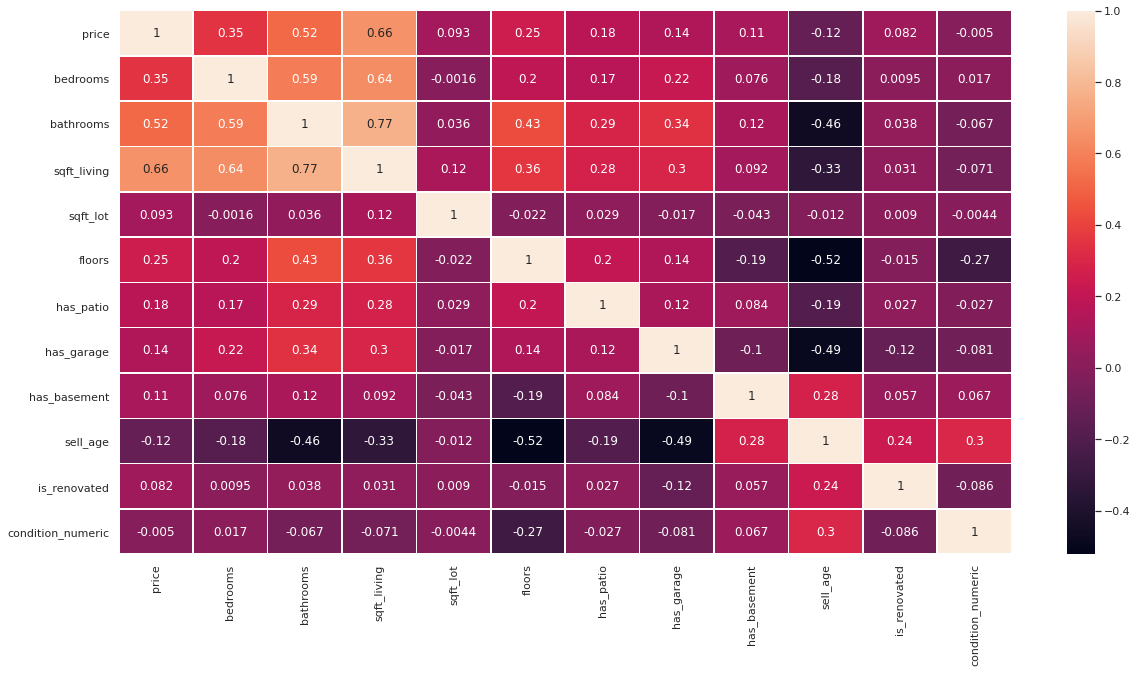

In [121]:
#heatmaps with correlation

plt.figure(figsize = (20,10))
sns.heatmap(numeric_homes.corr(), annot = True, linewidths=.5)


# Running simple regression based on most correlated variable of sqft_living

In [122]:
#run a simple regression on this correlation
x = homes_df['sqft_living']
y = homes_df['price']
simple_model = sm.OLS(y, sm.add_constant(x)).fit()
sm_summary = simple_model.summary()
sm_summary #shows a low rquared at .430 but model is significant. for every 1 sqft change, price increases by 568

#note kurtosis is 8, no need ot log Y 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                 2.162e+04
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:02:04   Log-Likelihood:            -4.1602e+05
No. Observations:               28622   AIC:                         8.320e+05
Df Residuals:                   28620   BIC:                         8.321e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.948e+04   7284.756     12.283      0.000    7.52e+04    1.04e+05
sqft_living   463.5104      3.153    147.021      0.000     457.331     469.690
==============================================================================
Omnibus:                     8359.493   Durbin-Watson:                   1.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42814.144
Skew:                           1.321   Prob(JB):                         0.00
Kurtosis:                       8.378   Cond. No.                     5.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

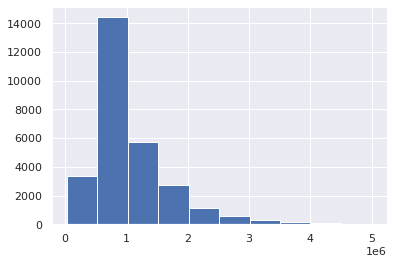

In [123]:
y.hist() #looking at skew. almost normal distbution, will not log Y. 

<AxesSubplot:>

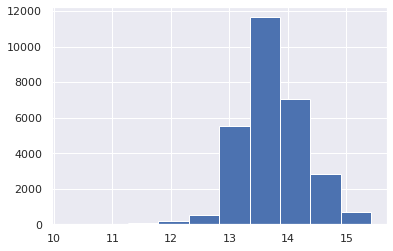

In [124]:
np.log(y).hist() #looking at skew. almost normal distbution, will not log Y. 

In [125]:
#looking at model of all numeric variables within dataset
x2 = numeric_homes.drop(['price'], axis = 1)
model = sm.OLS(y, sm.add_constant(x2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     2234.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:02:04   Log-Likelihood:            -4.1520e+05
No. Observations:               28622   AIC:                         8.304e+05
Df Residuals:                   28610   BIC:                         8.305e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.678e+05   2.09e+04     -8.040      0.000   -2.09e+05   -1.27e+05
bedrooms          -1.006e+05   3991.630    -25.201      0.000   -1.08e+05   -9.28e+04
bathrooms          9.612e+04   5980.791     16.071      0.000    8.44e+04    1.08e+05
sqft_living         480.4613      5.301     90.630      0.000     470.070     490.852
sqft_lot              0.1271      0.049      2.615      0.009       0.032       0.222
floors              8.09e+04   6680.872     12.109      0.000    6.78e+04     9.4e+04
has_patio         -1.262e+04   7234.404     -1.745      0.081   -2.68e+04    1556.393
has_garage         3547.3449   7290.221      0.487      0.627   -1.07e+04    1.78e+04
has_basement       1.547e+04   6367.936      2.429      0.015    2987.278     2.8e+04
sell_age           3242.8840    140.226     23.126      0.000    2968.034    3517.734
is_renovated       7.598e+04   1.46e+04      5.208      0.000    4.74e+04    1.05e+05
condition_numeric  2.453e+04   4401.611      5.573      0.000    1.59e+04    3.32e+04
==============================================================================
Omnibus:                     8313.881   Durbin-Watson:                   1.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46065.664
Skew:                           1.288   Prob(JB):                         0.00
Kurtosis:                       8.656   Cond. No.                     4.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note that the has garage, has_patio are  both are statistically insignificant and will remove the two and rerun. 
sqft lot almost insignificant but will remain in model. Skew went down. 

In [126]:
pd.options.display.float_format = '{:20,.2f}'.format

x3 = numeric_homes.drop(['price', 'has_garage', 'has_patio'], axis = 1)
log_model2 = sm.OLS(y, sm.add_constant(x3)).fit()
log_model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                   OLS                   Adj. R-squared:          0.462      
Dependent Variable:      price                 AIC:                     830419.8163
Date:                    2023-03-29 17:02      BIC:                     830502.4357
No. Observations:        28622                 Log-Likelihood:          -4.1520e+05
Df Model:                9                     F-statistic:             2730.      
Df Residuals:            28612                 Prob (F-statistic):      0.00       
R-squared:               0.462                 Scale:                   2.3319e+11 
-----------------------------------------------------------------------------------
                     Coef.      Std.Err.     t     P>|t|     [0.025       0.975]   
-----------------------------------------------------------------------------------
const             -169666.1478 19399.7616  -8.7458 0.0000 -207690.5903 -131641.7052
bedrooms          -100381.4501  3987.4370 -25.1744 0.0000 -108197.0135  -92565.8866
bathrooms           95776.9088  5965.4526  16.0553 0.0000   84084.3418  107469.4757
sqft_living           479.8268     5.2621  91.1852 0.0000     469.5128     490.1408
sqft_lot                0.1246     0.0485   2.5687 0.0102       0.0295       0.2197
floors              79334.8897  6524.9633  12.1587 0.0000   66545.6556   92124.1239
has_basement        14250.8311  6332.3961   2.2505 0.0244    1839.0377   26662.6245
sell_age             3234.6330   128.1919  25.2327 0.0000    2983.3709    3485.8951
is_renovated        74774.5469 14574.2708   5.1306 0.0000   46208.2927  103340.8012
condition_numeric   24260.8330  4394.2481   5.5210 0.0000   15647.9007   32873.7654
-----------------------------------------------------------------------------------
Omnibus:                   8315.260           Durbin-Watson:              1.161    
Prob(Omnibus):             0.000              Jarque-Bera (JB):           46042.059
Skew:                      1.288              Prob(JB):                   0.000    
Kurtosis:                  8.654              Condition No.:              436069   
===================================================================================
* The condition number is large (4e+05). This might indicate             strong
multicollinearity or other numerical problems.
"""

In [127]:
x4 = numeric_homes[['bedrooms','bathrooms','sqft_living','condition_numeric']]
multi_model = sm.OLS(y, sm.add_constant(x4)).fit()
mm_summary = multi_model.summary2()
print(mm_summary)

                         Results: Ordinary least squares
Model:                   OLS                  Adj. R-squared:         0.443      
Dependent Variable:      price                AIC:                    831379.4820
Date:                    2023-03-29 17:02     BIC:                    831420.7917
No. Observations:        28622                Log-Likelihood:         -4.1568e+05
Df Model:                4                    F-statistic:            5700.      
Df Residuals:            28617                Prob (F-statistic):     0.00       
R-squared:               0.443                Scale:                  2.4118e+11 
---------------------------------------------------------------------------------
                     Coef.     Std.Err.     t     P>|t|     [0.025       0.975]  
---------------------------------------------------------------------------------
const             113445.2307 15067.4079   7.5292 0.0000   83912.4047 142978.0567
bedrooms          -94263.8141  4004.3793 

Note: SQFT lot no longer statistically significant. 

In [128]:
x5 = numeric_homes[['is_renovated', 'sell_age','sqft_living']]
multi_model = sm.OLS(y, sm.add_constant(x5)).fit()
mm_summary = multi_model.summary()
mm_summary #this is a lower adj R, but conditioning number is much lower since less variables. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     7570.
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        17:02:04   Log-Likelihood:            -4.1571e+05
No. Observations:               28622   AIC:                         8.314e+05
Df Residuals:                   28618   BIC:                         8.315e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6.295e+04   1.01e+04     -6.219      0.000   -8.28e+04   -4.31e+04
is_renovated  1.183e+05   1.44e+04      8.232      0.000    9.02e+04    1.47e+05
sell_age      2076.7867    100.746     20.614      0.000    1879.319    2274.254
sqft_living    486.2634      3.332    145.926      0.000     479.732     492.795
==============================================================================
Omnibus:                     8222.312   Durbin-Watson:                   1.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43449.196
Skew:                           1.287   Prob(JB):                         0.00
Kurtosis:                       8.459   Cond. No.                     1.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Multi regression model using zip codes 

Create an OLS model that describes the zip code's ability to describe price. Output this as a dataframe object that can be called and indexed into.

In [129]:
# get zip codes by median price in said zip code and sort high to low
zip_by_price_median = homes_df[
    ['zip', 'price']].groupby(by='zip').agg(
        {'price': 'median', 'zip': 'size'}
).rename(
    columns={'zip': 'count'}
).reset_index()
zip_by_price_median.sort_values('price', ascending=False, inplace=True)
zip_by_price_median

,zip,price,count
3,98004,"2,672,500.00",258
24,98040,"2,300,000.00",323
4,98005,"1,956,000.00",178
21,98033,"1,832,687.50",600
38,98075,"1,830,500.00",410
...,...,...,...
12,98022,"567,230.00",454
2,98003,"550,000.00",439
20,98032,"549,950.00",183
63,98168,"540,000.00",383


In [130]:
dummy_zips = pd.get_dummies(homes_df['zip']).drop(
        zip_by_price_median.iloc[0]['zip'],         # <= select the highest-(median) priced zip to drop it
        axis=1
    )

In [131]:
# investigate the effect of zip code by itself

X = sm.add_constant(dummy_zips)

zip_model = sm.OLS(np.log(y), X).fit().summary2()
display(zip_by_price_median.iloc[0],print(zip_model))

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.441     
Dependent Variable: price            AIC:                31336.0286
Date:               2023-03-29 17:02 BIC:                31906.1018
No. Observations:   28622            Log-Likelihood:     -15599.   
Df Model:           68               F-statistic:        332.9     
Df Residuals:       28553            Prob (F-statistic): 0.00      
R-squared:          0.442            Scale:              0.17456   
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      14.7461     0.0260   566.9025   0.0000   14.6951   14.7971
98001      -1.4719     0.0309   -47.5856   0.0000   -1.5326   -1.4113
98002      -1.7263     0.0340   -50.7705   0.0000   -1.7930   -1.6597
98003      -1.5283     0.0328   -46.6290   0.0000   -1

zip                    98004
price           2,672,500.00
count                    258
Name: 3, dtype: object

None

In [132]:
homes_df.info() , dummy_zips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28622 entries, 0 to 29096
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 28622 non-null  int64  
 1   date               28622 non-null  object 
 2   price              28622 non-null  float64
 3   bedrooms           28622 non-null  int64  
 4   bathrooms          28622 non-null  float64
 5   sqft_living        28622 non-null  int64  
 6   sqft_lot           28622 non-null  int64  
 7   floors             28622 non-null  float64
 8   waterfront         28622 non-null  object 
 9   greenbelt          28622 non-null  object 
 10  view               28622 non-null  object 
 11  condition          28622 non-null  object 
 12  yr_built           28622 non-null  int64  
 13  zip                28622 non-null  object 
 14  town               28622 non-null  object 
 15  Zip Codes          28622 non-null  object 
 16  has_basement       286

(None, None)

In [133]:
zip_homes = pd.concat([numeric_homes['sqft_living'] , dummy_zips], axis=1)
X = sm.add_constant(zip_homes)

zip_model = sm.OLS(y, X).fit().summary2()
display(print(zip_model))#zip_by_price_median.iloc[0],

                        Results: Ordinary least squares
Model:                  OLS                  Adj. R-squared:         0.691      
Dependent Variable:     price                AIC:                    814610.9804
Date:                   2023-03-29 17:02     BIC:                    815189.3156
No. Observations:       28622                Log-Likelihood:         -4.0724e+05
Df Model:               69                   F-statistic:            928.0      
Df Residuals:           28552                Prob (F-statistic):     0.00       
R-squared:              0.692                Scale:                  1.3394e+11 
--------------------------------------------------------------------------------
                Coef.      Std.Err.     t     P>|t|      [0.025        0.975]   
--------------------------------------------------------------------------------
const        1616842.6166 24039.3525  67.2582 0.0000  1569724.3542  1663960.8791
sqft_living      388.7704     2.5551 152.1531 0.0000 

None

Create two graphs, one that displays the value of prices by zip code and one that 

''

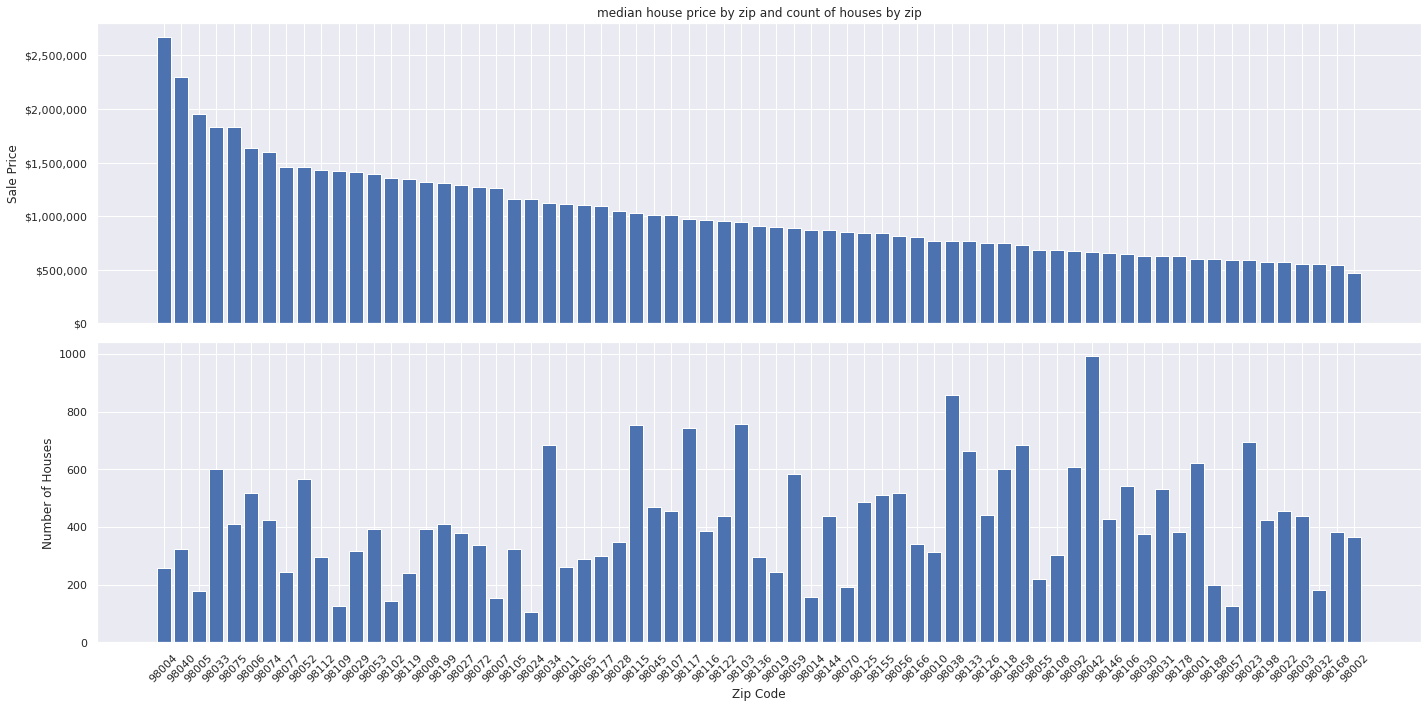

In [134]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

y = [zip_by_price_median['price'], zip_by_price_median['count']]
x = zip_by_price_median['zip']

ax[0].bar(x=x, height=y[0])
ax[1].bar(x=x, height=y[1])

ax[0].set(
    title='median house price by zip and count of houses by zip',
    ylabel='Sale Price'
)
ax[1].set(
    ylabel='Number of Houses',
    xlabel='Zip Code',
)

dollar_format = mtick.StrMethodFormatter('${x:,.0f}')
ax[0].yaxis.set_major_formatter(dollar_format)
plt.xticks(rotation=45)
plt.tight_layout()
''

model shows strong relation

look at highest zip (98004, already checked) - find adjacent zips (5 mile radius) and run from there

### zip 98004, Bellevue:
![Image of King County by Zip code centered on Bellevue (98004)](./img/kc_counties_98004.png)  
<sup>source: [https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/explore?location=47.613041%2C-122.082727%2C10.98]('https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/explore?location=47.613041%2C-122.082727%2C10.98')</sup>

### Counties within 5 miles of 98004:
![Image of King County by Zip code centered on Bellevue (98004)](./img/kc_counties_98004_prox.png)  
<sup>source: [https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/explore?location=47.613041%2C-122.082727%2C10.98]('https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/explore?location=47.613041%2C-122.082727%2C10.98')</sup>

limit to nearby zips  
zip codes within 5 miles of 98004

In [135]:
nearby_zips_df['ZIPCODE'] = nearby_zips_df['ZIPCODE'].astype(str)
nearby_homes_df = homes_df.merge(nearby_zips_df,how='inner',left_on='zip',right_on='ZIPCODE').drop(
    columns=['ZIP','ZIPCODE','PREFERRED_CITY']      #<= dropping columns from nearby_zips_df, they're redundant
    )
nearby_homes_df


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,town,Zip Codes,has_basement,has_garage,has_patio,is_renovated,sell_year,sell_age,condition_numeric,zip_counts
0,1604601802,12/14/2021,"775,000.00",3,3.00,2160,1400,2.00,NO,NO,...,Seattle,98118,1,1,1,0,2021,11,2.00,600
1,4006000502,10/27/2021,"700,000.00",6,3.50,1810,8519,1.00,NO,NO,...,Seattle,98118,1,1,1,0,2021,56,3.00,600
2,5249802390,3/3/2022,"274,380.00",2,1.00,1440,4000,1.00,NO,NO,...,Seattle,98118,1,0,1,1,2022,102,2.00,600
3,1105000058,10/28/2021,"599,000.00",4,2.00,1510,5013,1.50,NO,NO,...,Seattle,98118,0,0,1,1,2021,116,2.00,600
4,1704900215,5/12/2022,"1,100,000.00",3,2.00,1740,4883,1.00,NO,NO,...,Seattle,98118,1,0,1,1,2022,99,2.00,600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8103,9550204160,6/30/2021,"835,000.00",4,2.00,2280,3640,1.50,NO,NO,...,Seattle,98105,1,1,0,0,2021,92,2.00,323
8104,3131200640,6/24/2021,"1,250,000.00",3,2.00,1830,4590,2.00,NO,NO,...,Seattle,98105,1,0,1,0,2021,113,3.00,323
8105,3179100575,10/13/2021,"1,190,000.00",3,2.00,2060,6469,1.00,NO,NO,...,Seattle,98105,1,1,1,0,2021,71,4.00,323
8106,2862100450,6/24/2021,"1,160,000.00",5,3.00,1740,4400,1.00,NO,NO,...,Seattle,98105,1,1,1,0,2021,103,4.00,323


In [136]:
# same as zip by price median but only for nearby zips

nearby_zip_by_price_median = nearby_homes_df[
    ['zip', 'price']].groupby(by='zip').agg(
        {'price': 'median', 'zip': 'size'}
).rename(
    columns={'zip': 'count'}
).reset_index()
nearby_zip_by_price_median.sort_values('price', ascending=False, inplace=True)
nearby_zip_by_price_median

,zip,price,count
0,98004,"2,672,500.00",258
7,98040,"2,300,000.00",323
1,98005,"1,956,000.00",178
5,98033,"1,832,687.50",600
2,98006,"1,638,000.00",517
8,98052,"1,460,000.00",567
12,98112,"1,427,500.00",296
4,98008,"1,320,000.00",394
3,98007,"1,260,000.00",154
11,98105,"1,160,000.00",323


In [137]:
nearby_homes_df[numeric_columns].shape

(8108, 12)

In [138]:
pd.options.display.float_format = '{:20,.2f}'.format

In [139]:
# const       
# bedrooms    
# bathrooms   
# sqft_living 
# sqft_lot    
# floors      
# has_patio   
# has_garage  
# has_basement
# sell_age    
# is_renovated
# condition_numeric

In [212]:
y = nearby_homes_df['price']

nearby_zip_homes = pd.get_dummies(
    nearby_homes_df['zip']
    ).drop(
        '98004',         # <= drop 98004, highest cost
        axis=1
    )



X = sm.add_constant(
    pd.concat(
        [nearby_homes_df[numeric_columns[1:]],nearby_zip_homes],
        axis=1
    )
)
#y = np.log(y)
nearby_zip_model = sm.OLS(y, X).fit().summary2()
print(nearby_zip_model)

                           Results: Ordinary least squares
Model:                    OLS                    Adj. R-squared:           0.689      
Dependent Variable:       price                  AIC:                      234058.0667
Date:                     2023-03-29 17:58       BIC:                      234261.0843
No. Observations:         8108                   Log-Likelihood:           -1.1700e+05
Df Model:                 28                     F-statistic:              642.9      
Df Residuals:             8079                   Prob (F-statistic):       0.00       
R-squared:                0.690                  Scale:                    2.0091e+11 
--------------------------------------------------------------------------------------
                      Coef.      Std.Err.     t     P>|t|      [0.025        0.975]   
--------------------------------------------------------------------------------------
const              1289792.2789 46060.0935  28.0024 0.0000  1199502.627

In [213]:
#y = nearby_homes_df['price']

nearby_zip_homes = pd.get_dummies(
    nearby_homes_df['zip']
    ).drop(
        '98004',         # <= drop 98004, highest cost
        axis=1
    )



X = sm.add_constant(
    pd.concat(
        [
            nearby_homes_df[['bedrooms','bathrooms','sqft_living']],
            nearby_zip_homes
        ],
        axis=1
    )
)
#y = np.log(y)
nearby_zip_model = sm.OLS(y, X).fit()
print(nearby_zip_model.summary2())

                        Results: Ordinary least squares
Model:                  OLS                  Adj. R-squared:         0.683      
Dependent Variable:     price                AIC:                    234208.8586
Date:                   2023-03-29 17:58     BIC:                    234355.8713
No. Observations:       8108                 Log-Likelihood:         -1.1708e+05
Df Model:               20                   F-statistic:            874.4      
Df Residuals:           8087                 Prob (F-statistic):     0.00       
R-squared:              0.684                Scale:                  2.0488e+11 
--------------------------------------------------------------------------------
                Coef.      Std.Err.     t     P>|t|      [0.025        0.975]   
--------------------------------------------------------------------------------
const        1412708.8303 35282.0454  40.0404 0.0000  1343546.9407  1481870.7199
bedrooms      -81972.0660  6670.2822 -12.2891 0.0000 

In [214]:
prices_preds = nearby_zip_model.predict(X)
prices_resids = y - prices_preds

In [215]:
prices_preds.sort_values(ascending=False)

1195           7,882,664.44
1217           4,912,367.85
2294           4,754,852.80
4459           4,613,606.05
2136           4,426,104.80
               ...         
6075             243,248.56
5938             243,248.56
5628             232,787.11
5816             210,144.70
5883             204,913.97
Length: 8108, dtype: float64

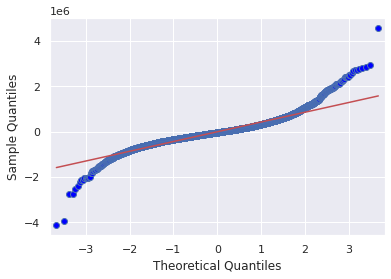

In [216]:
#fig, ax = plt.subplots(1,1)

##
sm.qqplot(prices_resids, line='r');

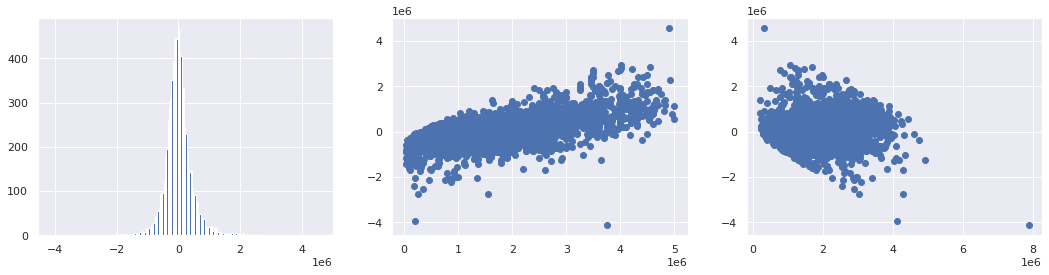

In [217]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].hist(prices_resids,bins='auto')
ax[1].scatter(y,prices_resids)
ax[2].scatter(prices_preds,prices_resids)
'';

In [224]:
nearby_zip_model.summary2().tables[1].sort_values('Coef.')

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
98059,"-1,424,367.86","34,039.36",-41.84,0.00,"-1,491,093.76","-1,357,641.97"
98056,"-1,359,252.58","34,850.19",-39.00,0.00,"-1,427,567.92","-1,290,937.23"
98118,"-1,305,572.77","34,376.37",-37.98,0.00,"-1,372,959.31","-1,238,186.24"
98125,"-1,219,627.06","35,466.79",-34.39,0.00,"-1,289,151.10","-1,150,103.02"
98144,"-1,150,116.83","36,138.25",-31.83,0.00,"-1,220,957.10","-1,079,276.56"
98034,"-1,065,956.07","33,494.38",-31.82,0.00,"-1,131,613.68","-1,000,298.47"
98122,"-1,054,326.53","36,244.12",-29.09,0.00,"-1,125,374.32","-983,278.73"
98115,"-1,047,814.40","33,216.08",-31.55,0.00,"-1,112,926.47","-982,702.33"
98105,"-952,961.49","38,163.67",-24.97,0.00,"-1,027,772.11","-878,150.88"
98007,"-940,663.77","46,378.36",-20.28,0.00,"-1,031,577.29","-849,750.26"


<hr />

# CREATE VISUALS - REMOVE IN FINAL

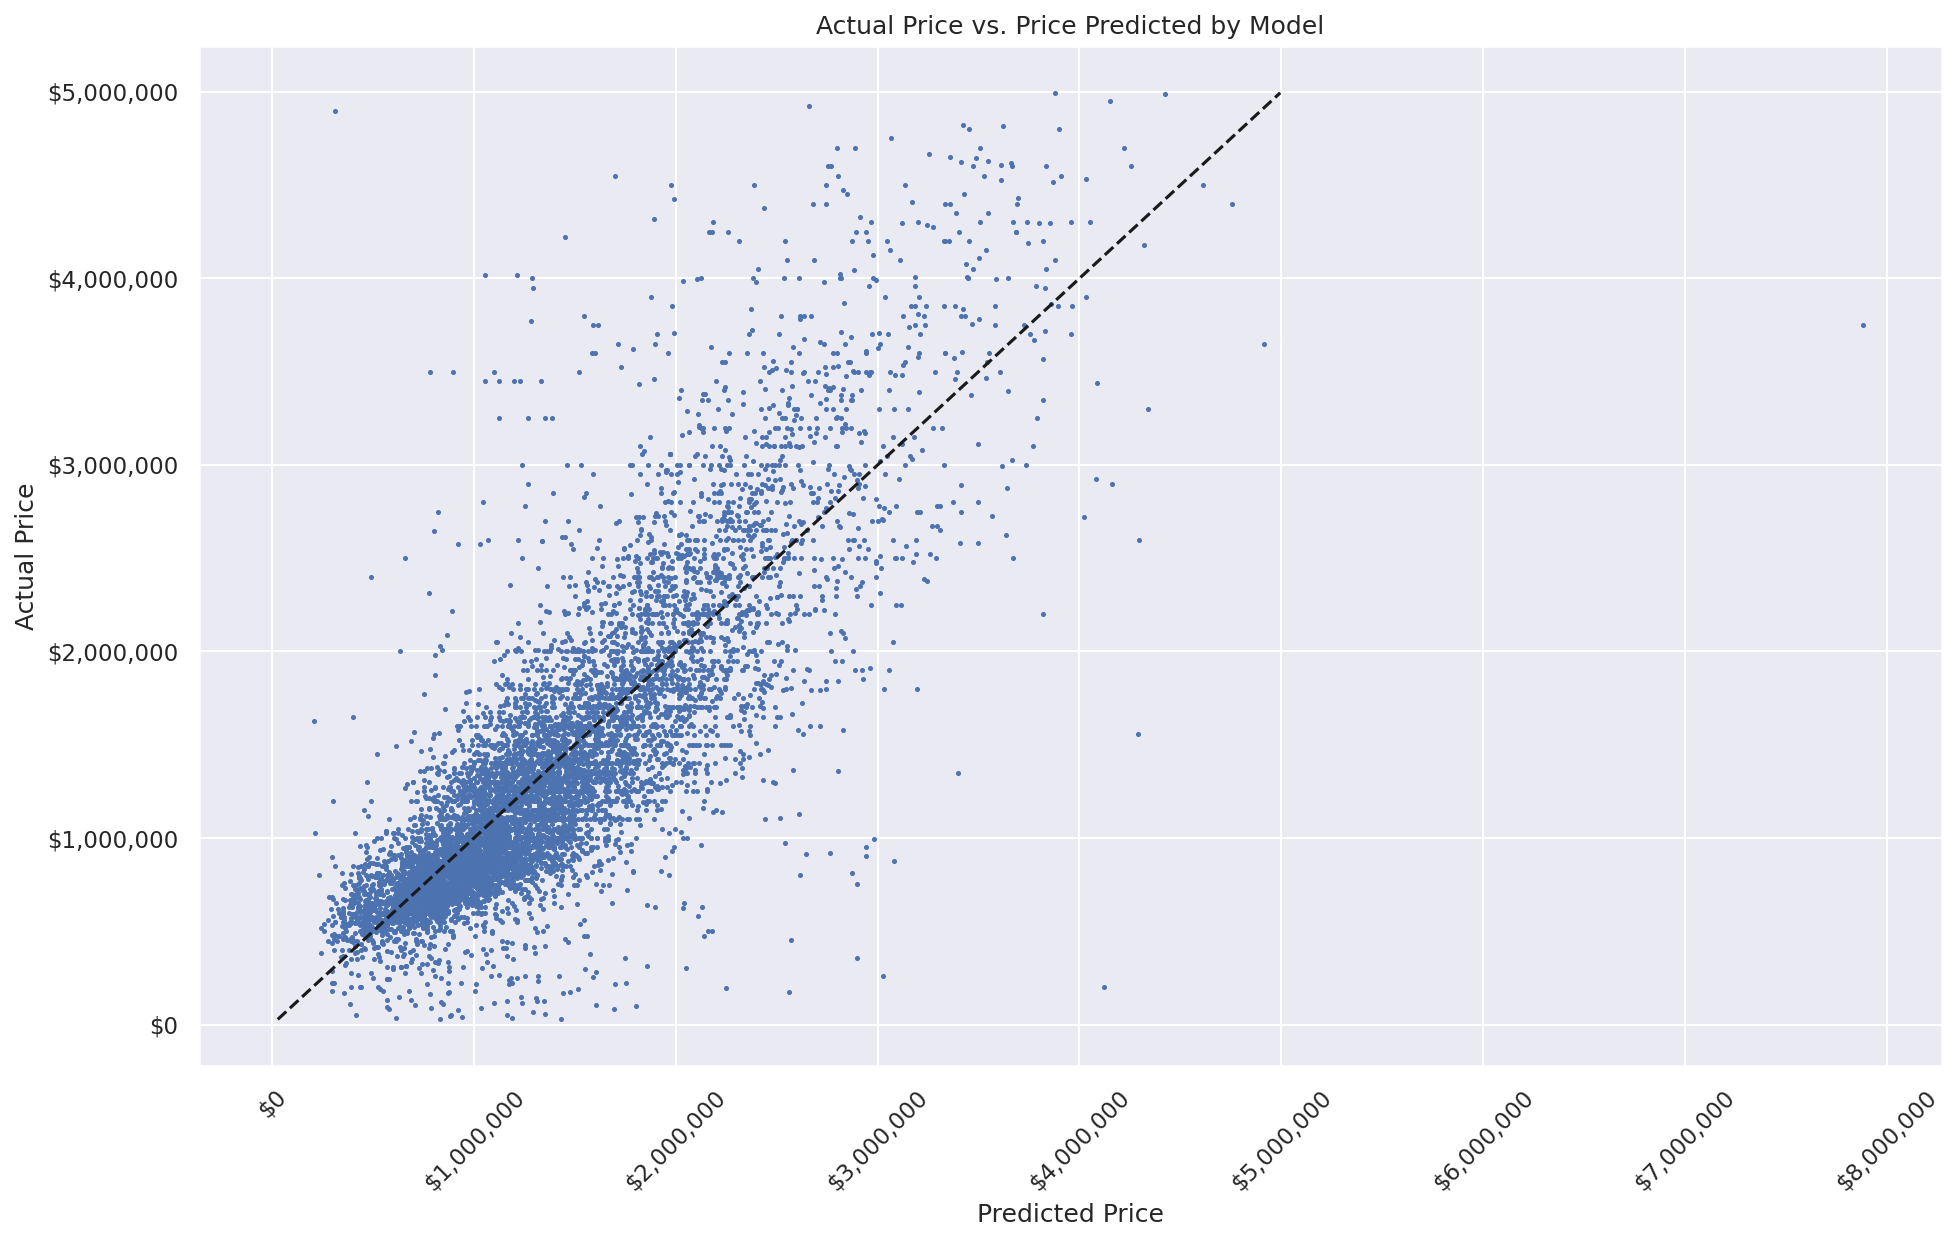

In [221]:
fig, ax = plt.subplots(figsize=(15,9), dpi=150)

ax.scatter(prices_preds , y , s=2)
ax.plot([y.min(),y.max()],
    [y.min(),y.max()],
    'k--'
)

dollar_format = mtick.StrMethodFormatter('${x:,.0f}')

ax.set(
    title='Actual Price vs. Price Predicted by Model',
    xlabel='Predicted Price',
    ylabel='Actual Price'
)
ax.yaxis.set_major_formatter(dollar_format)
ax.xaxis.set_major_formatter(dollar_format)
plt.xticks(rotation=45)

'';